# Customer Churn Prediction on E-commerce Data

**Business Task:**

The goal of this analysis is to use e-commerce data for an online store to predict whether a customer will churn. Customer churn will be defined as not placing another order within the next 60 days. A binary classification model will be built. The emphasis of this project will be based on prediction.

**Dataset Information:**

The online retail dataset was obtained from the UCI machine learning repository. This dataset contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The dataset can be accessed here: https://archive.ics.uci.edu/dataset/352/online+retail

## Import Libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load and Inspect Data

In [4]:
retail_df = pd.read_excel("/Users/naregkedjejian/Downloads/UCI Online Retail Dataset.xlsx", header=0)

In [5]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
retail_df.shape

(541909, 8)

In [667]:
retail_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Negative values are errors in data entry.

In [10]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [11]:
retail_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
retail_df.duplicated().sum()

5268

In [572]:
retail_df[["UnitPrice", "Quantity"]][(
    retail_df["InvoiceNo"].str.lower().str[0] == "c")].describe()

,UnitPrice,Quantity
count,9288.000000,9288.000000
mean,48.393661,-29.885228
std,666.600430,1145.786965
min,0.010000,-80995.000000
25%,1.450000,-6.000000
50%,2.950000,-2.000000
75%,5.950000,-1.000000
max,38970.000000,-1.000000


In [573]:
retail_df["UnitPrice"][(retail_df["UnitPrice"] < 0)]

299983   -11062.06
299984   -11062.06
Name: UnitPrice, dtype: float64

In [574]:
retail_df.loc[(retail_df["UnitPrice"] < 0), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Negative quantities are due to cancelled orders. Negative prices are due to adjusted bad debt; since these are not associated with a customer ID, they are not relevant.

## Feature Engineering

In [854]:
retail_df_2 = retail_df.copy()

In [855]:
# Creating a column to determine if a customer has cancelled an order
retail_df_2["CancelledOrder"] = (retail_df_2["InvoiceNo"].str.lower().str[0] == "c").astype("Int64")

In [856]:
# Creating a column to calculate total spent on an item
retail_df_2["TotalPricePerItem"] = retail_df_2["Quantity"]*retail_df_2["UnitPrice"]

In [857]:
# Creating a column to calculate total spent on an invoice
retail_df_2["TotalInvoicePrice"] = retail_df_2.groupby("InvoiceNo")["TotalPricePerItem"].transform("sum")

In [858]:
# Creating a column to calculate total items bought for an invoice
retail_df_2["TotalInvoiceItems"] = retail_df_2.groupby("InvoiceNo")["Quantity"].transform("sum")

In [859]:
# Creating a column to calculate the total items bought by each customer
retail_df_2["TotalItemsBought"] = retail_df_2.groupby("CustomerID")["Quantity"].transform("sum").astype("Int64")

In [860]:
# Creating a column to calculate the total money spent by each customer
retail_df_2["TotalMoneySpent"] = retail_df_2.groupby("CustomerID")["TotalPricePerItem"].transform("sum")

A column for churn will be created. The most recent date in the dataset is December 9, 2011. A customer has churned if they have not made a purchase since 90 days before December 9, 2011, which is September 10, 2011.

In [861]:
# Creating a column to calculate the date of the most recent purchase by each customer
retail_df_2["LastPurchase"] = retail_df_2.groupby("CustomerID")["InvoiceDate"].transform("max")

In [862]:
retail_df_2["Churned"] = (retail_df_2["LastPurchase"] < pd.to_datetime("2011-09-10")).astype("Int64")

In [867]:
retail_df_2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledOrder,TotalPricePerItem,TotalInvoicePrice,TotalInvoiceItems,TotalItemsBought,TotalMoneySpent,LastPurchase,Churned
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,139.12,40,1693,5288.63,2011-02-10 14:38:00,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,139.12,40,1693,5288.63,2011-02-10 14:38:00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1


In [876]:
retail_df_2.groupby("CustomerID")["Churned"].max().value_counts()

Churned
0    2918
1    1454
Name: count, dtype: Int64

## Data Cleaning

In [885]:
retail_df_3 = retail_df_2.copy()

In [886]:
retail_df_3.shape

(541909, 16)

In [887]:
retail_df_3.isna().sum()

InvoiceNo                 0
StockCode                 0
Description            1454
Quantity                  0
InvoiceDate               0
UnitPrice                 0
CustomerID           135080
Country                   0
CancelledOrder            0
TotalPricePerItem         0
TotalInvoicePrice         0
TotalInvoiceItems         0
TotalItemsBought     135080
TotalMoneySpent      135080
LastPurchase         135080
Churned                   0
dtype: int64

In [888]:
retail_df_3.duplicated().sum()

5268

All the duplicated rows and rows with missing `CustomerID` values need to be dropped.

In [889]:
retail_df_3 = retail_df_3.dropna(subset="CustomerID")

In [890]:
retail_df_3 = retail_df_3.drop_duplicates()

In [891]:
retail_df_3.shape

(401604, 16)

In [893]:
retail_df_3.isna().sum().sum()

0

In [894]:
retail_df_3.duplicated().sum()

0

There are no more missing or duplicate values.

In [895]:
retail_df_3.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,401604.0,12.183273,-80995.0,2.0,5.0,12.0,80995.0,250.283037
InvoiceDate,401604,2011-07-10 12:08:23.848567552,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:40:00,2011-10-20 11:58:30,2011-12-09 12:50:00,NaN
UnitPrice,401604.0,3.474064,0.0,1.25,1.95,3.75,38970.0,69.764035
CustomerID,401604.0,15281.160818,12346.0,13939.0,15145.0,16784.0,18287.0,1714.006089
CancelledOrder,401604.0,0.022091,0.0,0.0,0.0,0.0,1.0,0.146981
TotalPricePerItem,401604.0,20.613638,-168469.6,4.25,11.7,19.8,168469.6,430.352218
TotalInvoicePrice,401604.0,727.858183,-168469.6,242.39,387.31,683.91,168469.6,1509.585452
TotalInvoiceItems,401604.0,422.466646,-80995.0,128.0,234.0,427.0,80995.0,893.874271
TotalItemsBought,401604.0,6555.743247,-303.0,635.0,1560.0,3725.0,196719.0,18871.957959
TotalMoneySpent,401604.0,11146.796104,-4287.63,1093.65,2628.93,6180.49,279489.02,30306.39976


## Transform Dataset from Purchase-Level to Customer-Level Granularity

In [956]:
retail_df_4 = retail_df_3.copy()

In [957]:
retail_df_4["NumberOfCancelledOrders"] = retail_df_4.groupby("CustomerID")["CancelledOrder"].transform("sum")

In [958]:
retail_df_4["NumberOfNonCancelledOrders"] = retail_df_4.groupby(
    "CustomerID")["InvoiceNo"].transform("nunique") - retail_df_4["NumberOfCancelledOrders"]

In [959]:
retail_df_4["NumberOfInvoices"] = retail_df_4["NumberOfNonCancelledOrders"] + retail_df_4["NumberOfCancelledOrders"]

In [961]:
retail_df_4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledOrder,TotalPricePerItem,TotalInvoicePrice,TotalInvoiceItems,TotalItemsBought,TotalMoneySpent,LastPurchase,Churned,NumberOfCancelledOrders,NumberOfNonCancelledOrders,NumberOfInvoices
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,139.12,40,1693,5288.63,2011-02-10 14:38:00,1,12,23,35
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1,12,23,35
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,139.12,40,1693,5288.63,2011-02-10 14:38:00,1,12,23,35
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1,12,23,35
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,139.12,40,1693,5288.63,2011-02-10 14:38:00,1,12,23,35


In [962]:
# Creating invoice aggregate columns
non_cancelled = retail_df_4[retail_df_4["CancelledOrder"] == 0]
invoice_stats = non_cancelled.groupby("CustomerID")["TotalInvoicePrice"].agg([
    "mean", "std", "max"]).fillna(0)
invoice_stats.columns = ["MeanPriceOfInvoice", "StdDvOfInvoice", "LargestInvoice"]
invoice_stats.head()

,MeanPriceOfInvoice,StdDvOfInvoice,LargestInvoice
CustomerID,,,
12346.0,77183.600000,0.000000,77183.60
12347.0,737.259560,352.597549,1294.32
12348.0,622.814194,305.388108,892.80
12349.0,1757.550000,0.000000,1757.55
12350.0,334.400000,0.000000,334.40


In [963]:
retail_df_4 = retail_df_4.merge(invoice_stats, how="outer", on="CustomerID").fillna(0)

Some people will have missing values if they only have cancelled orders, so those invoice statistics will be filled with the value 0.

In [964]:
retail_df_4[retail_df_4["CustomerID"] == 13256.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledOrder,TotalPricePerItem,...,TotalItemsBought,TotalMoneySpent,LastPurchase,Churned,NumberOfCancelledOrders,NumberOfNonCancelledOrders,NumberOfInvoices,MeanPriceOfInvoice,StdDvOfInvoice,LargestInvoice
64115,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0,0.0,...,12540,0.0,2011-11-25 15:57:00,0,0,1,1,0.0,0.0,0.0


Some `UnitPrice` values are 0 due to discounts/coupons.

In [965]:
# Creating item aggregate columns
items_purchased_stats = non_cancelled.groupby("CustomerID")["TotalInvoiceItems"].agg([
    "mean", "std", "max"]).fillna(0)
items_purchased_stats.columns = ["MeanOfTotalItemsPurchased", "StdDvOfTotalItemsPurchased", "LargestNumOfTotalItemsPurchased"]
items_purchased_stats.head()

,MeanOfTotalItemsPurchased,StdDvOfTotalItemsPurchased,LargestNumOfTotalItemsPurchased
CustomerID,,,
12346.0,74215.000000,0.000000,74215
12347.0,407.263736,177.564109,676
12348.0,868.387097,448.184090,1254
12349.0,631.000000,0.000000,631
12350.0,197.000000,0.000000,197


In [966]:
retail_df_4 = retail_df_4.merge(items_purchased_stats, how="outer", on="CustomerID").fillna(0)

In [967]:
# Fixing the churn column
retail_df_4["Churned"] = retail_df_4.groupby("CustomerID")["Churned"].transform("max")

In [968]:
retail_df_4.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'CancelledOrder',
       'TotalPricePerItem', 'TotalInvoicePrice', 'TotalInvoiceItems',
       'TotalItemsBought', 'TotalMoneySpent', 'LastPurchase', 'Churned',
       'NumberOfCancelledOrders', 'NumberOfNonCancelledOrders',
       'NumberOfInvoices', 'MeanPriceOfInvoice', 'StdDvOfInvoice',
       'LargestInvoice', 'MeanOfTotalItemsPurchased',
       'StdDvOfTotalItemsPurchased', 'LargestNumOfTotalItemsPurchased'],
      dtype='object')

In [969]:
retail_df_5 = retail_df_4.drop([
    "InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice",
    "CancelledOrder", "TotalPricePerItem", "TotalInvoicePrice", "TotalInvoiceItems", 
    "LastPurchase",  
], axis=1)

In [970]:
retail_df_5.columns

Index(['CustomerID', 'Country', 'TotalItemsBought', 'TotalMoneySpent',
       'Churned', 'NumberOfCancelledOrders', 'NumberOfNonCancelledOrders',
       'NumberOfInvoices', 'MeanPriceOfInvoice', 'StdDvOfInvoice',
       'LargestInvoice', 'MeanOfTotalItemsPurchased',
       'StdDvOfTotalItemsPurchased', 'LargestNumOfTotalItemsPurchased'],
      dtype='object')

In [972]:
retail_df_5.isna().sum().sum()

0

In [973]:
retail_df_5.shape

(401604, 14)

In [974]:
retail_df_5.head(10)

,CustomerID,Country,TotalItemsBought,TotalMoneySpent,Churned,NumberOfCancelledOrders,NumberOfNonCancelledOrders,NumberOfInvoices,MeanPriceOfInvoice,StdDvOfInvoice,LargestInvoice,MeanOfTotalItemsPurchased,StdDvOfTotalItemsPurchased,LargestNumOfTotalItemsPurchased
0,12346.0,United Kingdom,0,0.0,1,1,1,2,77183.60000,0.000000,77183.60,74215.000000,0.000000,74215.0
1,12346.0,United Kingdom,0,0.0,1,1,1,2,77183.60000,0.000000,77183.60,74215.000000,0.000000,74215.0
2,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
3,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
4,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
5,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
6,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
7,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
8,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0
9,12347.0,Iceland,2458,4310.0,0,0,7,7,737.25956,352.597549,1294.32,407.263736,177.564109,676.0


In [975]:
retail_df_5["CustomerID"].nunique()

4372

In [976]:
retail_df_5.shape[0] - retail_df_5.duplicated().sum()

4380

There is a discrepency of 8 rows.

In [977]:
retail_df_5 = retail_df_5.drop_duplicates()

In [978]:
retail_df_5.shape

(4380, 14)

In [979]:
retail_df_5["CustomerID"].value_counts().sort_values(ascending=False).head(10)

CustomerID
12417.0    2
12394.0    2
12455.0    2
12431.0    2
12429.0    2
12422.0    2
12457.0    2
12370.0    2
12353.0    1
12359.0    1
Name: count, dtype: int64

In [980]:
retail_df_5[(retail_df_5["CustomerID"].isin([
    12370.0, 12431.0, 12422.0, 12457.0, 12394.0, 12429.0, 12455.0, 12417.0]))].sort_values(by="CustomerID")

,CustomerID,Country,TotalItemsBought,TotalMoneySpent,Churned,NumberOfCancelledOrders,NumberOfNonCancelledOrders,NumberOfInvoices,MeanPriceOfInvoice,StdDvOfInvoice,LargestInvoice,MeanOfTotalItemsPurchased,StdDvOfTotalItemsPurchased,LargestNumOfTotalItemsPurchased
1490,12370.0,Cyprus,2353,3545.69,0,0,4,4,1195.225301,416.055564,1590.82,810.132530,275.789369,1005.0
1572,12370.0,Austria,2353,3545.69,0,0,4,4,1195.225301,416.055564,1590.82,810.132530,275.789369,1005.0
2798,12394.0,Belgium,819,1272.48,0,0,2,2,494.484444,216.201800,891.40,283.111111,192.764969,637.0
2819,12394.0,Denmark,819,1272.48,0,0,2,2,494.484444,216.201800,891.40,283.111111,192.764969,637.0
4667,12417.0,Belgium,1539,3578.80,0,6,6,12,426.687292,80.310790,562.69,193.161458,87.273416,344.0
4718,12417.0,Spain,1539,3578.80,0,6,6,12,426.687292,80.310790,562.69,193.161458,87.273416,344.0
4974,12422.0,Australia,370,803.56,1,0,3,3,302.425128,112.673592,417.36,135.256410,38.920106,175.0
4987,12422.0,Switzerland,370,803.56,1,0,3,3,302.425128,112.673592,417.36,135.256410,38.920106,175.0
5570,12429.0,Denmark,1557,3750.40,0,0,4,4,947.558969,300.144574,1281.50,396.484536,114.296500,512.0
5590,12429.0,Austria,1557,3750.40,0,0,4,4,947.558969,300.144574,1281.50,396.484536,114.296500,512.0


All the repeat customer IDs are from customers who placed orders in multiple countries. These rows will be removed.

In [981]:
retail_df_6 = retail_df_5[~(retail_df_5["CustomerID"].isin([
    12370.0, 12431.0, 12422.0, 12457.0, 12394.0, 12429.0, 12455.0, 12417.0]))]

In [982]:
retail_df_6.shape

(4364, 14)

In [983]:
retail_df_6.head()

,CustomerID,Country,TotalItemsBought,TotalMoneySpent,Churned,NumberOfCancelledOrders,NumberOfNonCancelledOrders,NumberOfInvoices,MeanPriceOfInvoice,StdDvOfInvoice,LargestInvoice,MeanOfTotalItemsPurchased,StdDvOfTotalItemsPurchased,LargestNumOfTotalItemsPurchased
0,12346.0,United Kingdom,0,0.00,1,1,1,2,77183.600000,0.000000,77183.60,74215.000000,0.000000,74215.0
2,12347.0,Iceland,2458,4310.00,0,0,7,7,737.259560,352.597549,1294.32,407.263736,177.564109,676.0
184,12348.0,Finland,2341,1797.24,0,0,4,4,622.814194,305.388108,892.80,868.387097,448.184090,1254.0
215,12349.0,Italy,631,1757.55,0,0,1,1,1757.550000,0.000000,1757.55,631.000000,0.000000,631.0
288,12350.0,Norway,197,334.40,1,0,1,1,334.400000,0.000000,334.40,197.000000,0.000000,197.0


### One-hot Encoding

In [986]:
retail_df_6["Country"].value_counts(normalize=True)

Country
United Kingdom          0.905133
Germany                 0.021769
France                  0.019936
Spain                   0.006645
Belgium                 0.005041
Portugal                0.004354
Switzerland             0.004354
Italy                   0.003437
Finland                 0.002750
Norway                  0.002291
Netherlands             0.002062
Austria                 0.002062
Channel Islands         0.002062
Sweden                  0.001833
Japan                   0.001833
Denmark                 0.001604
Australia               0.001604
Poland                  0.001375
Cyprus                  0.001146
USA                     0.000917
Canada                  0.000917
Greece                  0.000917
Israel                  0.000917
Unspecified             0.000917
EIRE                    0.000687
United Arab Emirates    0.000458
Bahrain                 0.000458
Malta                   0.000458
Saudi Arabia            0.000229
Singapore               0.000229
Ic

In [987]:
retail_df_6.loc[(retail_df_6["Country"] != "United Kingdom"), "Country"] = "Other"

In [988]:
retail_df_6["Country"].value_counts()

Country
United Kingdom    3950
Other              414
Name: count, dtype: int64

In [989]:
retail_df_6 = pd.get_dummies(retail_df_6, columns=["Country"], drop_first=True, dtype=int)

## Exploratory Data Analysis

### Univariate Analysis

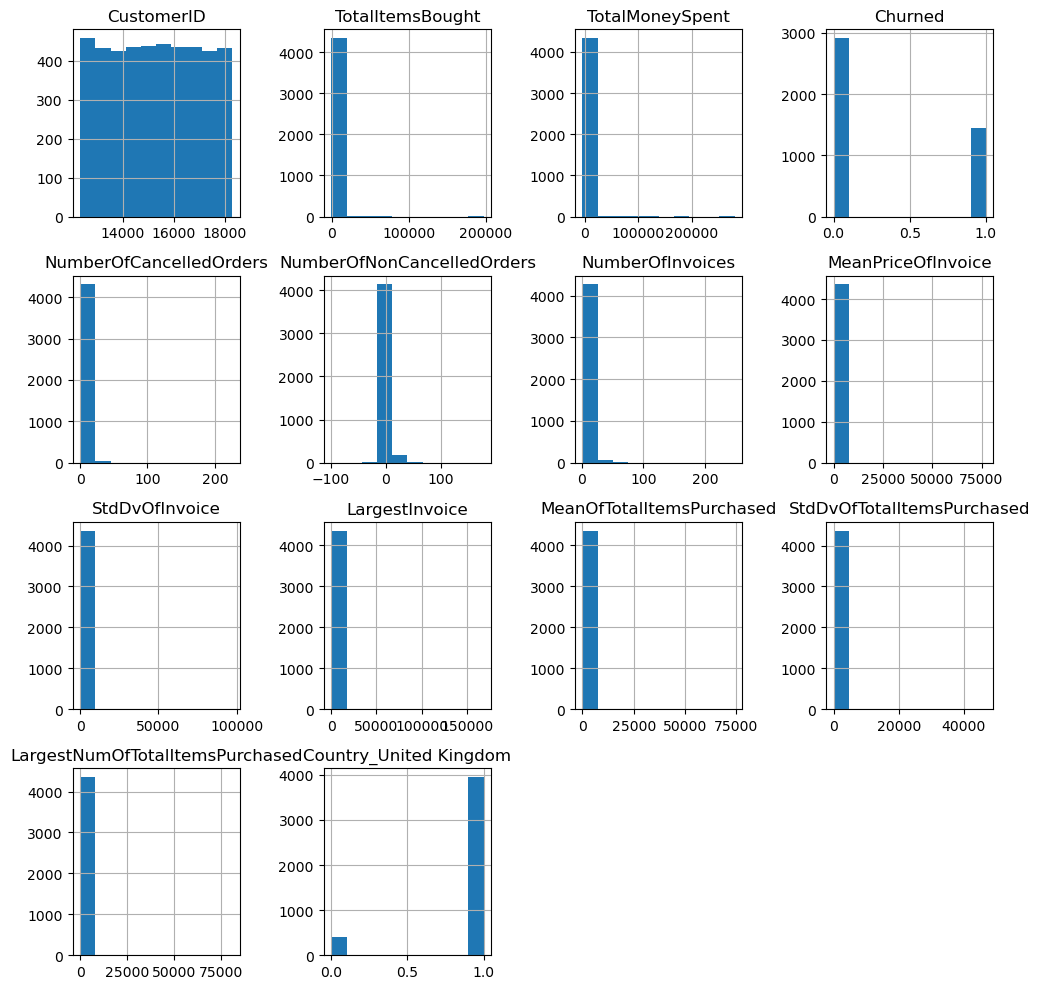

In [990]:
retail_df_6.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

In [991]:
retail_df_6.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4364.0,15304.953254,1719.550736,12346.0,13820.5,15306.5,16780.25,18287.0
TotalItemsBought,4364.0,1121.585243,4676.908557,-303.0,152.0,364.5,959.5,196719.0
TotalMoneySpent,4364.0,1896.497217,8226.441041,-4287.63,292.6575,646.49,1607.2275,279489.02
Churned,4364.0,0.332951,0.471323,0.0,0.0,0.0,1.0,1.0
NumberOfCancelledOrders,4364.0,2.02956,7.322022,0.0,0.0,0.0,1.0,226.0
NumberOfNonCancelledOrders,4364.0,3.041247,6.731186,-99.0,1.0,2.0,4.0,178.0
NumberOfInvoices,4364.0,5.070807,9.343879,1.0,1.0,3.0,5.0,248.0
MeanPriceOfInvoice,4364.0,468.453213,1573.22843,0.0,192.297725,313.303453,487.804531,77183.6
StdDvOfInvoice,4364.0,137.206661,1542.695632,0.0,0.0,39.707845,116.5888,97264.294594
LargestInvoice,4364.0,650.270385,3080.517307,0.0,218.5075,365.3,616.33,168469.6


In [992]:
retail_df_6.skew().sort_values(ascending=False)

StdDvOfTotalItemsPurchased         58.950364
StdDvOfInvoice                     58.017002
MeanOfTotalItemsPurchased          48.399547
LargestInvoice                     41.747899
MeanPriceOfInvoice                 37.552947
LargestNumOfTotalItemsPurchased    37.155375
TotalItemsBought                   22.954806
TotalMoneySpent                    21.689555
NumberOfCancelledOrders            13.104037
NumberOfInvoices                   11.415126
NumberOfNonCancelledOrders           4.63127
Churned                             0.709174
CustomerID                          0.000317
Country_United Kingdom             -2.766068
dtype: Float64

All the features appear to be extremely skewed. The target variable `Churned` is not skewed and has balanced classes. A classification model that is robust to skewed features must be used.

### Correlation Analysis

In [993]:
# correlation matrix
corr_matrix = retail_df_6.corr(numeric_only=True)

# Unstack the matrix into a Series
corr_pairs = corr_matrix.abs().unstack()

# Drop self-correlations (where row == column)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Drop duplicate pairs (since correlation is symmetric)
corr_pairs = corr_pairs.drop_duplicates().sort_values(ascending=False)

corr_pairs.head(20)

StdDvOfInvoice              StdDvOfTotalItemsPurchased         0.966778
MeanPriceOfInvoice          LargestNumOfTotalItemsPurchased    0.938504
                            MeanOfTotalItemsPurchased          0.926135
TotalItemsBought            TotalMoneySpent                    0.921653
LargestInvoice              LargestNumOfTotalItemsPurchased    0.915757
StdDvOfInvoice              LargestInvoice                     0.900814
MeanOfTotalItemsPurchased   LargestNumOfTotalItemsPurchased    0.884165
LargestInvoice              StdDvOfTotalItemsPurchased         0.874198
MeanPriceOfInvoice          LargestInvoice                     0.870399
StdDvOfTotalItemsPurchased  LargestNumOfTotalItemsPurchased    0.745457
StdDvOfInvoice              LargestNumOfTotalItemsPurchased    0.711112
NumberOfCancelledOrders     NumberOfInvoices                   0.698748
LargestInvoice              MeanOfTotalItemsPurchased          0.680121
NumberOfNonCancelledOrders  NumberOfInvoices                   0

## Model Preparation

In [1040]:
X = retail_df_6.drop(["CustomerID", "Churned"], axis=1)
y = retail_df_6["Churned"]

In [1041]:
X.shape

(4364, 12)

In [1042]:
y.shape

(4364,)

In [1043]:
y.value_counts(normalize=True)

Churned
0    0.667049
1    0.332951
Name: proportion, dtype: Float64

In [1044]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=11)

In [1045]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

## Model Fitting and Evaluation

### Random Forest

In [1132]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=11)

param_grid_rf = {
    "n_estimators": [10, 15, 25, 50],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 3, 5, 7, 10, 20],
    "max_depth": [6,8,10,None]
}

grid_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, 
                       cv=5, scoring='f1', n_jobs=-1, verbose=1)

In [1133]:
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
y_prob_rf = grid_rf.predict_proba(X_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [1134]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'n_estimators': 15}

In [1089]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

def evaluate_model(y_true, y_pred, y_pred_proba=None, show_report=True, plot_curves=True):
    """
    Evaluate performance of a binary classification model.
    
    Parameters:
    - y_true: array-like, true binary labels
    - y_pred: array-like, predicted binary labels (0 or 1)
    - y_pred_proba: array-like or None, predicted probabilities for the positive class
    - show_report: bool, if True prints the classification report
    - plot_curves: bool, if True and y_pred_proba is provided, plots ROC and Precision-Recall curves
    
    Returns:
    - metrics: dict of evaluation scores
    """

    metrics = {}

    # Core metrics
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
    metrics["f1_score"] = f1_score(y_true, y_pred, zero_division=0)

    # Confusion Matrix
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred)

    # Print report if needed
    if show_report:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))

    # If probabilities are available, compute AUC metrics and plot curves
    if y_pred_proba is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, y_pred_proba)

            precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
            metrics["pr_auc"] = auc(recall_vals, precision_vals)

            if plot_curves:
                from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

                RocCurveDisplay.from_predictions(y_true, y_pred_proba)
                plt.title("ROC Curve")
                plt.show()

                PrecisionRecallDisplay(precision=precision_vals, recall=recall_vals).plot()
                plt.title("Precision-Recall Curve")
                plt.show()
        except ValueError as e:
            print(f"Skipping ROC/PR AUC computation and plotting: {e}")

    return metrics



Classification Report:
              precision    recall  f1-score   support

         0.0     0.7691    0.8272    0.7971       874
         1.0     0.5919    0.5023    0.5434       436

    accuracy                         0.7191      1310
   macro avg     0.6805    0.6648    0.6703      1310
weighted avg     0.7102    0.7191    0.7127      1310



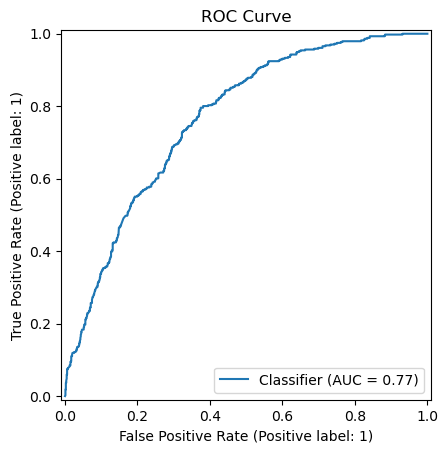

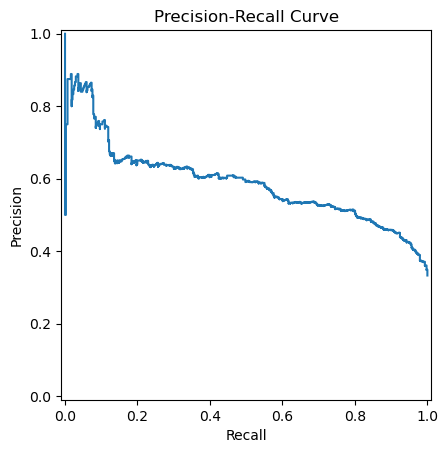

{'accuracy': 0.7190839694656489,
 'precision': 0.5918918918918918,
 'recall': 0.5022935779816514,
 'f1_score': 0.543424317617866,
 'confusion_matrix': array([[723, 151],
        [217, 219]]),
 'roc_auc': 0.765547257153654,
 'pr_auc': 0.5872803305488165}

In [1135]:
evaluate_model(y_test, y_pred_rf, y_prob_rf[:, 1], show_report=True, plot_curves=True)

In [1136]:
import pickle

with open('grid_rf.pkl', 'wb') as f:
    pickle.dump(grid_rf, f)

In [1137]:
# Checking to see if the model overfits
y_pred_train_rf = grid_rf.predict(X_train)
y_prob_train_rf = grid_rf.predict_proba(X_train)

In [1138]:
evaluate_model(
    y_train, y_pred_train_rf, y_prob_train_rf[:, 1], show_report=True, plot_curves=False)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.8136    0.8827    0.8467      2037
         1.0     0.7168    0.5949    0.6502      1017

    accuracy                         0.7868      3054
   macro avg     0.7652    0.7388    0.7485      3054
weighted avg     0.7814    0.7868    0.7813      3054



{'accuracy': 0.7868369351669942,
 'precision': 0.716824644549763,
 'recall': 0.5948869223205506,
 'f1_score': 0.6501880709296077,
 'confusion_matrix': array([[1798,  239],
        [ 412,  605]]),
 'roc_auc': 0.8832923269562263,
 'pr_auc': 0.7743600224664006}

### Gradient Boosting 

In [1146]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb = XGBClassifier(eval_metric='mlogloss', random_state=11)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 7, None],
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.5, 1.0]
}

grid_xgb = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_xgb,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

In [1147]:
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)
y_prob_xgb = grid_xgb.predict_proba(X_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [1148]:
grid_xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.5}


Classification Report:
              precision    recall  f1-score   support

         0.0     0.7618    0.8307    0.7947       874
         1.0     0.5854    0.4794    0.5271       436

    accuracy                         0.7137      1310
   macro avg     0.6736    0.6550    0.6609      1310
weighted avg     0.7031    0.7137    0.7057      1310



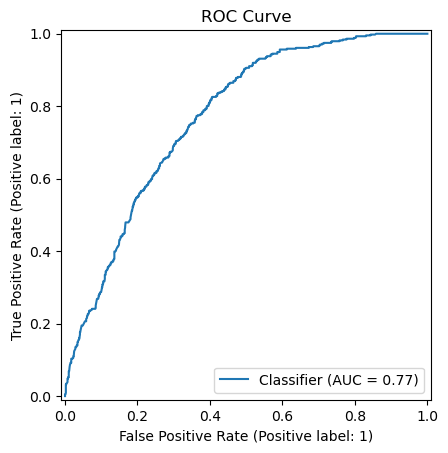

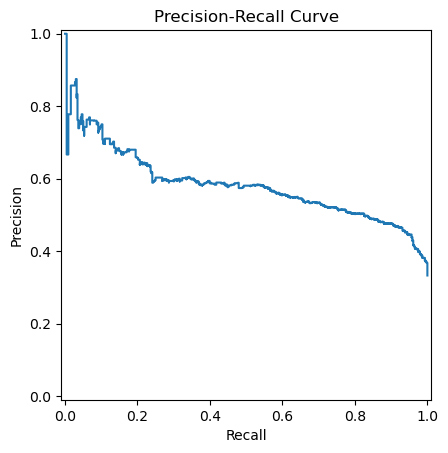

{'accuracy': 0.7137404580152672,
 'precision': 0.5854341736694678,
 'recall': 0.4793577981651376,
 'f1_score': 0.5271122320302648,
 'confusion_matrix': array([[726, 148],
        [227, 209]]),
 'roc_auc': 0.7696502424789537,
 'pr_auc': 0.5805668853621551}

In [1149]:
evaluate_model(y_test, y_pred_xgb, y_prob_xgb[:, 1], show_report=True, plot_curves=True)

In [1150]:
with open('grid_xgb.pkl', 'wb') as f:
    pickle.dump(grid_xgb, f)

In [1151]:
# Checking to see if the model overfits
y_pred_train_xgb = grid_xgb.predict(X_train)
y_prob_train_xgb = grid_xgb.predict_proba(X_train)

In [1152]:
evaluate_model(
    y_train, y_pred_train_xgb, y_prob_train_xgb[:, 1], show_report=True, plot_curves=False)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.7774    0.8557    0.8147      2037
         1.0     0.6379    0.5093    0.5664      1017

    accuracy                         0.7403      3054
   macro avg     0.7077    0.6825    0.6906      3054
weighted avg     0.7310    0.7403    0.7320      3054



{'accuracy': 0.7403405370006548,
 'precision': 0.6379310344827587,
 'recall': 0.5093411996066863,
 'f1_score': 0.5664297430289775,
 'confusion_matrix': array([[1743,  294],
        [ 499,  518]]),
 'roc_auc': 0.8032623119294043,
 'pr_auc': 0.6611623471811862}

### K Nearest Neighbors

In [1067]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(estimator=knn,
                           param_grid=param_grid_knn,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)

In [1068]:
grid_knn.fit(X_train, y_train)
y_pred_knn = grid_knn.predict(X_test)
y_prob_knn = grid_knn.predict_proba(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [1153]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


Classification Report:
              precision    recall  f1-score   support

         0.0     0.7492    0.8307    0.7878       874
         1.0     0.5660    0.4427    0.4968       436

    accuracy                         0.7015      1310
   macro avg     0.6576    0.6367    0.6423      1310
weighted avg     0.6882    0.7015    0.6910      1310



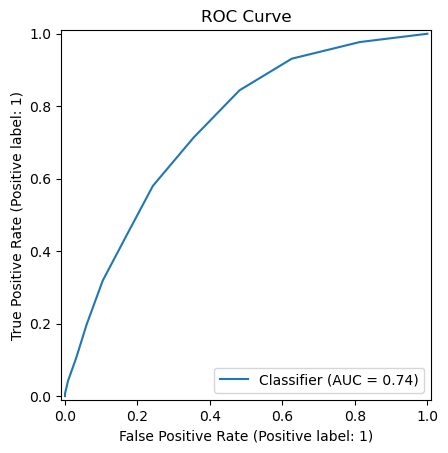

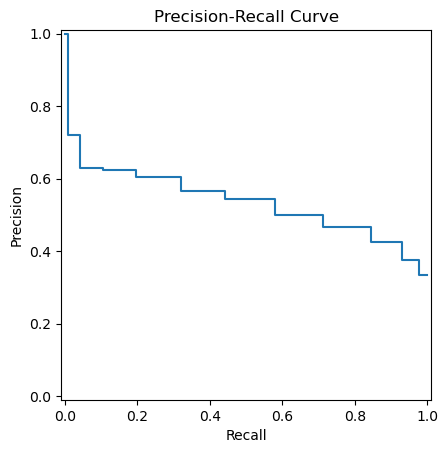

{'accuracy': 0.7015267175572519,
 'precision': 0.5659824046920822,
 'recall': 0.4426605504587156,
 'f1_score': 0.4967824967824968,
 'confusion_matrix': array([[726, 148],
        [243, 193]]),
 'roc_auc': 0.742774179665358,
 'pr_auc': 0.558870105994784}

In [1154]:
evaluate_model(y_test, y_pred_knn, y_prob_knn[:, 1], show_report=True, plot_curves=True)

In [1155]:
with open('grid_knn.pkl', 'wb') as f:
    pickle.dump(grid_knn, f)

In [1156]:
# Checking to see if the model overfits
y_pred_train_knn = grid_knn.predict(X_train)
y_prob_train_knn = grid_knn.predict_proba(X_train)

In [1157]:
evaluate_model(
    y_train, y_pred_train_knn, y_prob_train_knn[:, 1], show_report=True, plot_curves=False)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.7871    0.8640    0.8238      2037
         1.0     0.6614    0.5320    0.5896      1017

    accuracy                         0.7534      3054
   macro avg     0.7242    0.6980    0.7067      3054
weighted avg     0.7452    0.7534    0.7458      3054



{'accuracy': 0.7534381139489195,
 'precision': 0.6613691931540342,
 'recall': 0.5319567354965585,
 'f1_score': 0.5896457765667575,
 'confusion_matrix': array([[1760,  277],
        [ 476,  541]]),
 'roc_auc': 0.8149873843241237,
 'pr_auc': 0.6763934580503849}

### Stacking

In [1161]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ('grid_rf', grid_rf.best_estimator_),
        ('grid_xgb', grid_xgb.best_estimator_),
        ('grid_knn', grid_knn.best_estimator_)
    ]
)

param_grid_voting = {
    "voting": ["soft", "hard"],
    "weights": [[1,1,1],
               [2,1,1],
               [3,1,1],
               [4,1,1]]
}

grid_voting = GridSearchCV(voting, param_grid_voting, 
                             cv=5, scoring='f1', n_jobs=-1, verbose=1)

In [1162]:
grid_voting.fit(X_train, y_train)
y_pred_voting = grid_voting.predict(X_test)
#y_prob_voting = grid_voting.predict_proba(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [1163]:
grid_voting.best_params_

{'voting': 'hard', 'weights': [3, 1, 1]}

In [1164]:
evaluate_model(
    y_test, y_pred_voting, show_report=True, plot_curves=True)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.7691    0.8272    0.7971       874
         1.0     0.5919    0.5023    0.5434       436

    accuracy                         0.7191      1310
   macro avg     0.6805    0.6648    0.6703      1310
weighted avg     0.7102    0.7191    0.7127      1310



{'accuracy': 0.7190839694656489,
 'precision': 0.5918918918918918,
 'recall': 0.5022935779816514,
 'f1_score': 0.543424317617866,
 'confusion_matrix': array([[723, 151],
        [217, 219]])}

In [1165]:
with open('grid_voting.pkl', 'wb') as f:
    pickle.dump(grid_voting, f)

In [1166]:
# Checking to see if the model overfits
y_pred_train_voting = grid_voting.predict(X_train)
#y_prob_train_voting = grid_voting.predict_proba(X_train)

In [1167]:
evaluate_model(
    y_train, y_pred_train_voting, show_report=True, plot_curves=False)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.8136    0.8827    0.8467      2037
         1.0     0.7168    0.5949    0.6502      1017

    accuracy                         0.7868      3054
   macro avg     0.7652    0.7388    0.7485      3054
weighted avg     0.7814    0.7868    0.7813      3054



{'accuracy': 0.7868369351669942,
 'precision': 0.716824644549763,
 'recall': 0.5948869223205506,
 'f1_score': 0.6501880709296077,
 'confusion_matrix': array([[1798,  239],
        [ 412,  605]])}

Of the three models tested, Random Forest produced the highest accuracy and f1 score. Therefore, Random Forest is determined to be the best model.

## Model Agnostic Explanations

### Permuation Feature Importance

In [1168]:
from sklearn.inspection import permutation_importance

# Compute importances on the test set
permutation_importance = permutation_importance(
    grid_rf, X_test, y_test, n_repeats=30, random_state=11, n_jobs=-1)

# Convert results to a DataFrame for readability
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': permutation_importance.importances_mean,
    'importance_std': permutation_importance.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance_mean', ascending=False)
print(importance_df)

                            feature  importance_mean  importance_std
0                  TotalItemsBought         0.107964        0.017994
1                   TotalMoneySpent         0.063034        0.012335
4                  NumberOfInvoices         0.062185        0.010434
10  LargestNumOfTotalItemsPurchased         0.040719        0.007951
6                    StdDvOfInvoice         0.029697        0.012769
7                    LargestInvoice         0.004440        0.007459
5                MeanPriceOfInvoice         0.003354        0.008629
11           Country_United Kingdom         0.000510        0.001206
2           NumberOfCancelledOrders        -0.000386        0.003815
3        NumberOfNonCancelledOrders        -0.003089        0.007281
8         MeanOfTotalItemsPurchased        -0.010072        0.007999
9        StdDvOfTotalItemsPurchased        -0.013615        0.010026


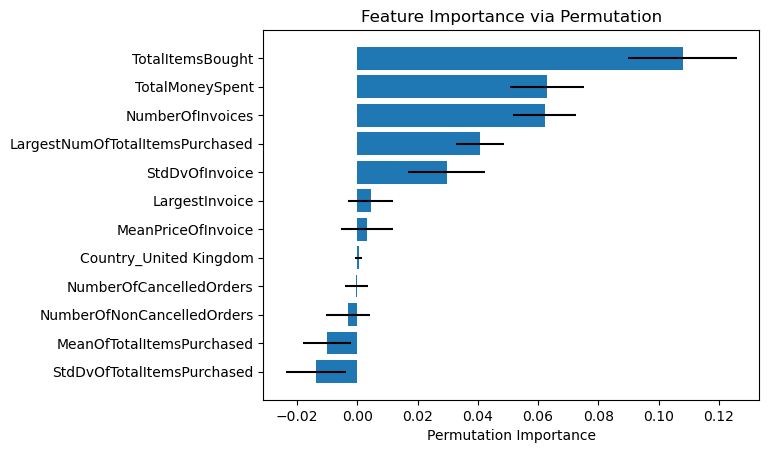

In [1169]:
# Visualize feature importance
plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.gca().invert_yaxis()
plt.show()

The features `TotalItemsBought`, `TotalMoneySpent`, and `NumberOfInvoices` have the largest importance means. Shuffling their values decreases the model's performance on average by 10.8%, 6.3%, and 6.2%, respectively.

### Partial Dependence Plot

In [1170]:
X.columns[[0,1,4]]

Index(['TotalItemsBought', 'TotalMoneySpent', 'NumberOfInvoices'], dtype='object')

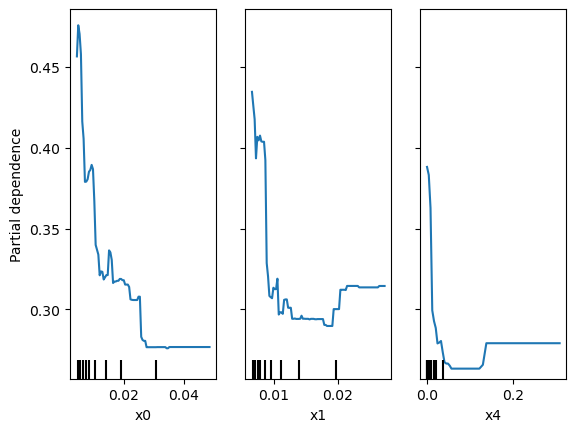

In [1171]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    estimator = grid_rf,
    X = X_test,
    features = [0,1,4]
)
plt.show()

The three plots represent how the probability of churn changes based on the value of `TotalItemsBought`, `TotalMoneySpent`, and `NumberOfInvoices`. Note that the features have been scaled with `MinMaxScaler`, so the x axis ranges from 0 to 1.

All three of the most important features have sharp downward peaks as their values begin to increase. This indicates that as customers buy more items, place more orders, and spend more money, the probability of churning decreases. We can also confirm this with some summary statistics shown below.

In [1124]:
retail_df_6.groupby("Churned")["TotalItemsBought"].mean()

Churned
0    1507.708691
1     348.009635
Name: TotalItemsBought, dtype: Float64

In [1126]:
retail_df_6.groupby("Churned")["TotalMoneySpent"].mean()

Churned
0    2555.933787
1     575.354853
Name: TotalMoneySpent, dtype: float64

In [1125]:
retail_df_6.groupby("Churned")["NumberOfInvoices"].mean()

Churned
0    6.538647
1    2.130076
Name: NumberOfInvoices, dtype: Float64

In [1173]:
?grid_rf.predict

Signature: grid_rf.predict(X)
Docstring:
Call predict on the estimator with the best found parameters.

Only available if ``refit=True`` and the underlying estimator supports
``predict``.

Parameters
----------
X : indexable, length n_samples
    Must fulfill the input assumptions of the
    underlying estimator.

Returns
-------
y_pred : ndarray of shape (n_samples,)
    The predicted labels or values for `X` based on the estimator with
    the best found parameters.
File:      /opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py
Type:      method